# Milestone 3: Text analysis - Predicting genre bigrams
The hypothesis behind this model was that the textual information about movies would be predictive of the genres. In order to model this, we used a Dirichlet multinomial Bayesian model. 

In [18]:
%matplotlib inline

import os
import nltk
import random
import itertools
import numpy as np
import pandas as pd
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
random.seed(42)

## Grabbing the data
For now, we have a total sample of around 50,000 movies. For this model, however, we worked with a random sample of 5,000 films. We also only looked at the textual data (`overview` and `reviews`) and the list of genres (`genres`). 

In [2]:
raw = pd.read_json('../../data/themoviedb-5k-sample-4-15-2017.json')
print(raw.shape)

# Keeping only genres, overviews, and reviews
raw = raw[['genres', 'reviews', 'overview']].copy()
print(raw.shape)
raw.head()

(5000, 29)
(5000, 3)


,genres,reviews,overview
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ..."


## Determining $y$: Converting `genres` to bigrams
How do we predict a multiple label list of genres for each film? For this model, we reduce the dimensionality of prediction by, instead, predicting most-poplar bigrams for each movie. A movie, for example, that has `[Drama, Adventure, Romance, Comedy]` listed as genres will instead be reduced to `(Drama, Adventure)`, as that is the most popular genre that the film has listed. A film with only one movie genre listed, `[Documentary]`, would become the "unary" bigram of `(Documentary,)`. 

In practice, this means:
- We convert all lists of genres into bigrams.
- We calculate the frequency of each bigram.
- For each movie, we select the bigram that occurs most frequently across all movies. (One note: this will over-sample over-represented classes.) 
- This final bigram which we use for prediction is `popular_bigram`. 

In [3]:
all_bigrams_ever = []

def bigrams(row):
    return zip(row['genre_lists'], row['genre_lists'][1:])

def col_for_each_bigram(row):
    for bigram in row['genre_bigrams']:            
        all_bigrams_ever.append(tuple(sorted(bigram)))
    return row

def popular_bigram(row):
    for k in row['genre_bigrams']:
        if bigram_frequency[k] <= 50 and len(row['genre_lists']) != 1:
            row['popular_bigram'] = 'Other'
        elif k in OrderedDict(bigram_frequency.most_common()).keys() and row['popular_bigram'] != k:
            row['popular_bigram'] = k
    if len(row['genre_lists']) == 1:
        row['popular_bigram'] = tuple(row['genre_lists'])
    return row
                
raw['genre_lists'] = raw.apply(lambda x: [y['name'] for y in x['genres']], axis = 1)
raw['genre_bigrams'] = raw.apply(lambda x: bigrams(x), axis = 1)
raw['popular_bigram'] = np.nan
raw = raw.apply(lambda x: col_for_each_bigram(x), axis = 1)
bigram_frequency = Counter(all_bigrams_ever)
raw = raw.apply(lambda x: popular_bigram(x), axis = 1)
raw.head()

,genres,reviews,overview,genre_lists,genre_bigrams,popular_bigram
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...,[Documentary],[],"(Documentary,)"
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...,[Documentary],[],"(Documentary,)"
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...,[Action],[],"(Action,)"
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)"
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ...","[Music, Comedy, Drama, Romance]","[(Music, Comedy), (Comedy, Drama), (Drama, Rom...","(Drama, Romance)"


#### How to deal with very rare genres?
Some genre bigrams appear less than 1% of the time. We drop these from the data entirely.

In [4]:
genre_frequency = raw['popular_bigram'].value_counts()
genre_frequency[-10:]

(Western,)            19
(Adventure, Drama)    16
(Fantasy,)            15
(Crime,)              13
(Adventure,)          12
(Foreign,)             6
(Mystery,)             4
(TV Movie,)            3
(War,)                 1
(History,)             1
Name: popular_bigram, dtype: int64

In [5]:
# Dropping "rare" movies (i.e. with a y < 1% of sample N)
rare_genres = genre_frequency[genre_frequency < (raw.shape[0]*0.01)].index
raw['drop'] = raw.apply(lambda x: 1 if x['popular_bigram'] in rare_genres else 0, axis = 1)
raw['drop'].value_counts()

0    4214
1     786
Name: drop, dtype: int64

In [6]:
# I'll drop movies with 'rare' genres
df = raw[(raw['drop'] == 0) | (raw['popular_bigram'] == 'Other')].copy()
df = df[df['popular_bigram'] != 'Other'].copy()
raw.shape, df.shape

((5000, 7), (2739, 7))

In [7]:
print(df['popular_bigram'].nunique())
df['popular_bigram'].value_counts()

16


(Documentary,)          667
(Drama,)                462
(Comedy,)               347
(Horror,)               171
(Drama, Romance)        171
(Music,)                131
(Drama, Thriller)       113
(Horror, Thriller)      107
(Comedy, Drama)         107
(Comedy, Romance)        87
(Thriller,)              84
(Action, Thriller)       62
(Documentary, Music)     61
(Crime, Drama)           61
(Action,)                56
(Animation,)             52
Name: popular_bigram, dtype: int64

Our final number of classes to predict is 16 distinct bigrams. The most frequently occurring is `(Documentary,)`, followed by `(Drama,)` and so on. We dropped everything that appears less than 1% of the time; the "rarest" genre remaining in our data is `(Animation,)`. 


## Converting `overview` and `reviews` to word-frequency vectors
For movie summaries and reviews, we turned these into word-frequency vectors. 

In [8]:
# I realized that sometimes 'overview' was in my top words list; renaming it here 'protects' it
df.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [9]:
df['review_text'] = df.apply(lambda row: [x['content'] for x in row['reviews']], axis = 1)
df = df.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(84019, 18506)

## Fitting the model
We have identified 18,506 unique words that appear, globally, across all the movie summaries. We cannot use all 18,506 word vectors, as we would then have the "curse of dimensionality" - an incredibly sparse matrix. Instead, following the Dirichlet homework, we only selected the most frequently occurring words as columns. Since this was akin to a tuning parameter, we cross-validated to find the optimal number of word vectors to include.

In [10]:
# Initialize model object
clf = MultinomialNB()

In [11]:
word_scores = []

for top_word_count in range(100, 900, 300):
    top_words = [word[0] for word in Counter(all_words_ever).most_common(top_word_count)]
    for word in top_words:
        df[unidecode(word)] = 0

    this_df = pd.DataFrame()
    this_df = df.apply(lambda x: parse_words(x), axis = 1)

    X = this_df[this_df.columns[-top_word_count:]]
    y = this_df['popular_bigram']
    y = y.apply(lambda x: str(x))
    print(X.shape, y.shape)

    scores = cross_val_score(clf, X, y, cv=5)
    word_scores.append({'top_word_count': top_word_count, 'average_score': scores.mean()})

word_scores = pd.DataFrame(word_scores)
word_scores.head()

((2739, 100), (2739,))
((2739, 400), (2739,))
((2739, 700), (2739,))


,average_score,top_word_count
0,0.354110,100
1,0.389510,400
2,0.412182,700


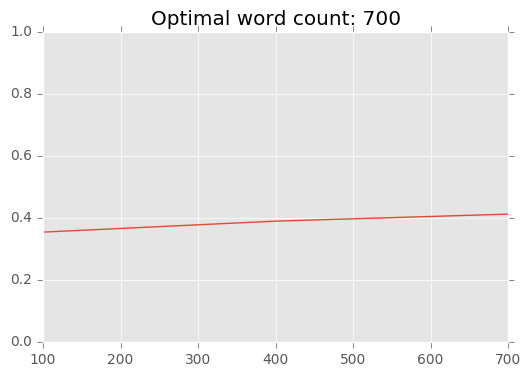

In [12]:
best_word_count = word_scores[word_scores['average_score'] == word_scores['average_score'].max()]['top_word_count'].item()

plt.plot(word_scores['top_word_count'], word_scores['average_score'])
plt.title('Optimal word count: {}'.format(best_word_count))
plt.ylim([0,1])
plt.show()

We have 16 unique genres which we are predicting. A random classifier would thus predict around 6% correctly. At present, we're able to predict with around 40% accuracy, using the top 500 words (by frequency) in film summary overviews.

### Confusion matrix

In [33]:
best_df = df.apply(lambda x: parse_words(x), axis = 1)

train = best_df.sample(frac = 0.8)
test = best_df.drop(train.index)
train.shape, test.shape

((2191, 708), (548, 708))

In [34]:
X_train = train[train.columns[-top_word_count:]]
X_test = test[test.columns[-top_word_count:]]
y_train = train['popular_bigram'].apply(lambda x: str(x))
y_test = test['popular_bigram'].apply(lambda x: str(x))
print(X_train.shape, X_test.shape)

((2191, 700), (548, 700))


In [35]:
fitted = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = fitted.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

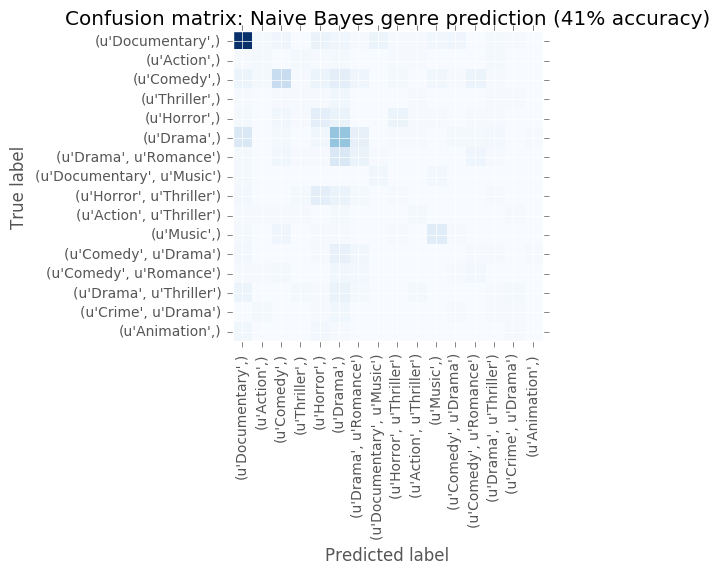

In [36]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Naive Bayes genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()

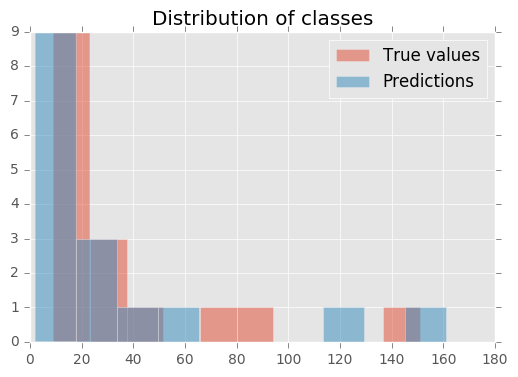

In [37]:
plt.hist(y_test.value_counts(), alpha = 0.5, label = 'True values')
plt.hist(pd.Series(y_pred).value_counts(), alpha = 0.5, label = 'Predictions')
plt.legend()
plt.title('Distribution of classes')
plt.show()